# US Housing Market Analysis

In [118]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
from bokeh.io import export_png
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Loading and cleaning data
Now That we've trained a model with a 6 month target using data from our custom dataset, we can do the same as before only now allowing for current 'Price Index', 'CPI', and 'Sales Price' since it's no longer predicting current values. The top 6 features from the previous model were:

* 'Price Index'
* 'CPI'
* 'Sales Price'
* 'NASDAQ'
* 'Lumber Price Index'
* 'Construction'


In [56]:
# Read in data
file_path = Path("data/housing_data5.csv")
df = pd.read_csv(file_path)
df.head()

,Date,Price Index,CPI,Sales Price,NASDAQ,Lumber Price Index,Construction
0,1987-01-01,63.734,111.2,97900.0,384.227143,108.1,1090.0
1,1987-02-01,64.134,111.6,97900.0,411.712632,109.4,1096.0
2,1987-03-01,64.469,112.1,97900.0,432.204545,110.6,1084.0
3,1987-04-01,64.973,112.7,103400.0,422.771429,110.7,1079.0
4,1987-05-01,65.547,113.1,103400.0,416.634000,110.7,1070.0


In [57]:
df.tail()

,Date,Price Index,CPI,Sales Price,NASDAQ,Lumber Price Index,Construction
428,2022-09-01,300.451,296.81,468000.0,11402.850000,322.849,1698.0
429,2022-10-01,298.672,298.01,479500.0,10801.494286,317.617,1710.0
430,2022-11-01,296.809,297.71,479500.0,10973.638095,312.864,1695.0
431,2022-12-01,294.266,296.80,479500.0,10838.995714,308.076,1696.0
432,2023-01-01,292.444,299.17,436800.0,11013.991000,306.461,1695.0


# Creating the new target

We're adding 'Price Index 6 Months Later' as a new target. This is the price index 6 months after the current month. We're doing this because we want to predict the price index 6 months from now, not the current price index.

In [58]:
# add a column 'Price Index 6 Months Later' to the dataframe and populate it with the price index 6 months later
df2 = df.copy()
df2['Price Index 6 Months Later'] = df2['Price Index'].shift(-6)
df2.tail(7)

,Date,Price Index,CPI,Sales Price,NASDAQ,Lumber Price Index,Construction,Price Index 6 Months Later
426,2022-07-01,307.135,296.28,468000.0,11622.631500,331.669,1683.0,292.444
427,2022-08-01,303.649,296.17,468000.0,12570.260435,329.173,1702.0,NaN
428,2022-09-01,300.451,296.81,468000.0,11402.850000,322.849,1698.0,NaN
429,2022-10-01,298.672,298.01,479500.0,10801.494286,317.617,1710.0,NaN
430,2022-11-01,296.809,297.71,479500.0,10973.638095,312.864,1695.0,NaN
431,2022-12-01,294.266,296.80,479500.0,10838.995714,308.076,1696.0,NaN
432,2023-01-01,292.444,299.17,436800.0,11013.991000,306.461,1695.0,NaN


# Defining the feature and target variables

For training this model, we need to drop the last 6 months of data, since we don't have the target for those months.

In [59]:
# Define features set
X = df2.copy()
X = X.drop("Date", axis=1)
X = X.drop("Price Index 6 Months Later", axis=1)
# drop last 6 rows
X = X[:-6]
X.head()

,Price Index,CPI,Sales Price,NASDAQ,Lumber Price Index,Construction
0,63.734,111.2,97900.0,384.227143,108.1,1090.0
1,64.134,111.6,97900.0,411.712632,109.4,1096.0
2,64.469,112.1,97900.0,432.204545,110.6,1084.0
3,64.973,112.7,103400.0,422.771429,110.7,1079.0
4,65.547,113.1,103400.0,416.634000,110.7,1070.0


In [60]:
# checking the shape of X and if there are any null values
print(X.shape)
print(X.isnull().sum())

(427, 6)
Price Index           0
CPI                   0
Sales Price           0
NASDAQ                0
Lumber Price Index    0
Construction          0
dtype: int64


# Creating the target vector 
Price Index = S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted)

In [61]:
# Define target vector 'Price Change' as y
y = df2["Price Index 6 Months Later"].values.reshape(-1, 1)
y = y[:-6]
y.shape

(427, 1)

# Splitting the data into training and testing sets

In [62]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [63]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [64]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

In [65]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled.shape

(107, 6)

# Fitting the Random Forest model

Having scaled the data, we can now fit the Random Forest model to the training data.

In [67]:
# create the random forrest classifier instance
rf_model = RandomForestRegressor(n_estimators=250, random_state=78)
# fit the model
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

# Making predictions with the Random Forest model

In [122]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)
len(predictions)

107

In [69]:
# compare predictions to actual values
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")


First 10 Predictions:   [212.726692  76.292416 297.993636 146.365764 140.016232 215.681552
 196.923912  76.574124 145.605244  79.229524]
First 10 Actual labels: [[212.25099999999998], [76.327], [300.45099999999996], [147.704], [140.69299999999998], [217.26], [196.90900000000002], [76.597], [143.868], [79.7]]


# Evaluating the Random Forest model

In [70]:
# chart of predictions vs actual
results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()})
# change the datatypes to float
results_df = results_df.astype("float64")
# add a column for the difference between the prediction and actual
results_df["Difference"] = results_df["Actual"] - results_df["Prediction"]
# add a column for the percent difference between the prediction and actual
results_df["Percent Difference"] = results_df["Difference"] / results_df["Actual"] * 100
# find the highest percent difference
results_df["Percent Difference"].max()
results_df.head(10)

,Prediction,Actual,Difference,Percent Difference
0,212.726692,212.251,-0.475692,-0.224118
1,76.292416,76.327,0.034584,0.045310
2,297.993636,300.451,2.457364,0.817892
3,146.365764,147.704,1.338236,0.906026
4,140.016232,140.693,0.676768,0.481025
5,215.681552,217.260,1.578448,0.726525
6,196.923912,196.909,-0.014912,-0.007573
7,76.574124,76.597,0.022876,0.029865
8,145.605244,143.868,-1.737244,-1.207526
9,79.229524,79.700,0.470476,0.590309


In [71]:
# use plotly express to create a histogram of the percent difference
fig = px.histogram(results_df, x="Percent Difference", title="Percent Difference Between Prediction and Actual")
fig.show()

In [72]:
# save the plot as a png file
scope = PlotlyScope()
with open("images/percent_difference_6_month_prediction.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))

In [73]:
# calculate the mean absolute error (MAE)
mae = results_df["Difference"].mean()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.26982616822427774


In [74]:
# calculate the mean squared error (MSE)
mse = results_df["Difference"].apply(lambda x: x**2).mean()
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 6.734939060305913


In [75]:
# calculate the root mean squared error (RMSE)
rmse = mse**(0.5)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 2.5951761135433395


In [76]:
# calculate the mean absolute percent error (MAPE)
mape = results_df["Percent Difference"].abs().mean()
print(f"Mean Absolute Percent Error: {mape}")


Mean Absolute Percent Error: 0.862317571201686


In [77]:
#evaluate the model
# score the model
rf_model.score(X_test_scaled, y_test)


0.9982281424556594

# Feature importance

In [78]:
# get the feature importance array
importances = rf_model.feature_importances_
# list of features
feature_list = list(X.columns)
# sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_list), reverse=True)
# print the feature importance
for feature in zip(feature_list, rf_model.feature_importances_):
    print(f"{feature[0]}: ({feature[1]})")
    

Price Index: (0.544561388932473)
CPI: (0.26031663251994486)
Sales Price: (0.09857783236269363)
NASDAQ: (0.05937817825938852)
Lumber Price Index: (0.027583816585928757)
Construction: (0.009582151339571352)


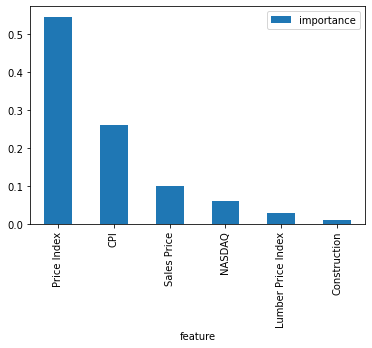

In [79]:
# add the feature importance to a dataframe
feature_importance_df = pd.DataFrame({"feature": feature_list, "importance": importances})
# sort the dataframe by the importance
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# set the index to be the feature
feature_importance_df = feature_importance_df.set_index("feature", drop=True)
# plot the feature importance
feature_importance_df.plot(kind="bar")
plt.show()

In [80]:
# use plotly to create a bar chart of the feature importance
fig = px.bar(feature_importance_df, x=feature_importance_df.index, y="importance", title="Feature Importance", color="importance", color_continuous_scale=px.colors.sequential.Cividis_r)
# save the graph
fig.write_image("images/feature_importance__6_month_prediction.png")
fig.show()

In [81]:
# define a function to output images of tables
def save_df_as_image(df, filename):
    source = ColumnDataSource(df)
    columns = [TableColumn(field=Ci, title=Ci) for Ci in df.columns]  # bokeh columns
    # add index column
    columns.insert(0, TableColumn(field="index", title="index"))
    # use df index as index column
    source.add(df.index, "index")
    data_table = DataTable(columns=columns, source=source, width=800, height=280)
    export_png(data_table, filename=filename)

In [82]:
# save a table of the feature importance
save_df_as_image(feature_importance_df, "images/feature_importance_6_month_prediction_table.png")

# Using the model on the full dataset

We can now use the model to predict the price index for the last 6 months of data.

In [84]:
# define a new feature set with all rows
X2 = df2.copy()
X2 = X2.drop("Date", axis=1)
X2 = X2.drop("Price Index 6 Months Later", axis=1)
X2.shape

(433, 6)

In [85]:
# scale the data
X2_scaled = X_scaler.transform(X2)
X2_scaled.shape

(433, 6)

In [121]:
# make predictions
predictions2 = rf_model.predict(X2_scaled)
len(predictions2)

433

In [87]:
# add the predictions to the dataframe
df2["Predictions"] = predictions2
df2.tail(7)

,Date,Price Index,CPI,Sales Price,NASDAQ,Lumber Price Index,Construction,Price Index 6 Months Later,Predictions
426,2022-07-01,307.135,296.28,468000.0,11622.631500,331.669,1683.0,292.444,294.464412
427,2022-08-01,303.649,296.17,468000.0,12570.260435,329.173,1702.0,NaN,296.020820
428,2022-09-01,300.451,296.81,468000.0,11402.850000,322.849,1698.0,NaN,293.806444
429,2022-10-01,298.672,298.01,479500.0,10801.494286,317.617,1710.0,NaN,289.955136
430,2022-11-01,296.809,297.71,479500.0,10973.638095,312.864,1695.0,NaN,290.945096
431,2022-12-01,294.266,296.80,479500.0,10838.995714,308.076,1696.0,NaN,290.216440
432,2023-01-01,292.444,299.17,436800.0,11013.991000,306.461,1695.0,NaN,291.035372


In [119]:
# create a new with only the date and price index
df3 = df2[["Date"]]
# convert the date to a datetime object
df3["Date"] = pd.to_datetime(df3["Date"])
# add 6 months of rows to the date
df3["Date"] = df3["Date"] + pd.DateOffset(months=6)
# add the price index to the dataframe
df3["Price Index"] = df2["Price Index 6 Months Later"]
# add the predictions to the dataframe
df3["Predictions"] = predictions2
df3.shape

(433, 3)

In [123]:
# use plotly to chart the 'Price Index 6 Months Later' and 'Predictions'
fig = px.line(df3, x="Date", y=["Price Index", "Predictions"], title="Price Index vs Predictions")
# add vertical line for the end of the actual data
fig.add_vline(x="2023-01-01", line_width=3, line_dash="dash", line_color="green", opacity=0.5)
# change the variable name 'Price Index 6 Months Later' to 'Price Index' in the legend
fig.for_each_trace(lambda t: t.update(name=t.name.replace("Price Index 6 Months Later", "Price Index")))
fig.show()

In [124]:
# save the graph
fig.write_image("images/price_index_vs_predictions_6_month_prediction_full.png")

In [116]:
# use plotly to chart the 'Price Index 6 Months Later' and 'Predictions'
fig = px.line(df3, x="Date", y=["Price Index", "Predictions"], title="Price Index vs Predictions")
# zoom in on data after 2020
fig.update_xaxes(range=["2020-01-01", "2023-07-01"])
# add vertical line for the end of the actual data
fig.add_vline(x="2023-01-01", line_width=3, line_dash="dash", line_color="green", opacity=0.5)
# change the variable name 'Price Index 6 Months Later' to 'Price Index' in the legend
fig.for_each_trace(lambda t: t.update(name=t.name.replace("Price Index 6 Months Later", "Price Index")))
fig.show()

In [117]:
# save the graph
fig.write_image("images/price_index_vs_predictions_6_month_prediction.png")